# Logistic_regression_model_with_sample_weighting

**Background:** Currently, my model's accuracy on the 0-class is quite poor, capping out around 50-63%. In order to improve the performance to be better than chance, I want to weight these cases higher when training. 

**Purpose:** To weight the class 0 cases higher when training

**Methods:**
>1. Introduction
>2. Inits

**Conclusions:**
* Therefore, using a `sample_weight_power` approximately equal to 1 yields the best performance for class 0
* There were no models using sample_weight_power that had < 500 features and > 50% accuracy on the class 0 cases
   * Therefore, I believe using sample weighting is not a good option for dealing with class imbalances

# Inits

## Imports

In [55]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context(context='notebook', font_scale=1.5)

import logging
logging.basicConfig()
logger = logging.getLogger()
logger.setLevel(logging.INFO)

from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.linear_model import LogisticRegression

import mlflow

# Load my own custom module
import data_loading
import constants

import imblearn
import joblib

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from plotnine import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/patsy/constraint.py:13: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


## Definitions

In [3]:
experiment_base_path = f'{constants.base_dir}/mlruns/'

test_param_dict = {'C': 1e-1,
             'max_iter': 100,
             'solver': 'saga',
             'class_weight': None,
             'lower_quantile_removed_CoV': 0}

## Funcs

### Running mlflow with sample weighting

In [44]:
def run_mlflow_exp_v6(curr_param_index, curr_params_dict):
    # Set the experiment name
    mlflow.set_tracking_uri(f'file://{experiment_base_path}')

    # Start a mlflow run
    with mlflow.start_run():
    #     mlflow.set_tag('description', 
    #     """
    #     """)

        # Define the model
        log_regr_clf = LogisticRegression(penalty='l1',
                                          C=curr_params_dict['C'],
                                          class_weight=curr_params_dict['class_weight'],
                                          random_state=110,
                                          solver=curr_params_dict['solver'],
                                          max_iter=curr_params_dict['max_iter'],
                                          verbose=0,
                                          n_jobs=None,
                                          l1_ratio=None)

        # Load the gene expression (GE) raw data from file
        X, y, phenotype_df = data_loading.load_sc1_data()

        # Remove the lowest quartile of genes based on CoV
        # Calculate the CoV
        gene_expr_cov_list = 100 * (X.std(ddof=1, axis=0) / X.mean(axis=0))

        # Calculate the 0.25 quantile
        min_cov_threshold = np.quantile(gene_expr_cov_list, q=[curr_params_dict['lower_quantile_removed_CoV']])[0]

        # Get a list of genes to removed
        low_cov_gene_list = gene_expr_cov_list.loc[(gene_expr_cov_list < min_cov_threshold)].index.tolist()

        # Remove the lowest 0.25 quantile of genes based on CoV
        X.drop(low_cov_gene_list, axis=1, inplace=True)

        # Split into CV/test set using target class to stratify
        X_cv, X_test, y_cv, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

        # Run custom CV so I can train on over-sampled data but test on original data
        kfold_obj = KFold(n_splits=5, shuffle=True)

        cv_train_accuracy_list = []
        cv_test_accuracy_list = []
        cv_test_accuracy_of_0_cases_list = []

        for curr_train_iloc_list, curr_test_iloc_list in kfold_obj.split(X=X_cv, y=y_cv):

            # Create current fold train data
            curr_fold_X_train = X_cv.iloc[curr_train_iloc_list, ]
            curr_fold_y_train = y_cv.iloc[curr_train_iloc_list, ]

            # Create current fold train data
            curr_fold_X_test = X_cv.iloc[curr_test_iloc_list, ]
            curr_fold_y_test = y_cv.iloc[curr_test_iloc_list, ]

            # Calculate the sample weights for this fold
            curr_fold_sample_weight_dict = ((1 / curr_fold_y_train.value_counts()) ** curr_params_dict['sample_weight_power']).to_dict()
            curr_fold_sample_weights = curr_fold_y_train.map(curr_fold_sample_weight_dict)

            # Train the model using sample weighting for this k-fold
            log_regr_clf.fit(curr_fold_X_train, curr_fold_y_train, sample_weight=curr_fold_sample_weights)

            # Calculate accuracy on non-oversampled data
            curr_fold_y_train_pred = pd.Series(log_regr_clf.predict(curr_fold_X_train), index=curr_fold_y_train.index)
            curr_fold_y_test_pred = pd.Series(log_regr_clf.predict(curr_fold_X_test), index=curr_fold_y_test.index)

            # Calculate result metrics like accuracy
            cv_train_accuracy_list.append((curr_fold_y_train_pred == curr_fold_y_train).mean())
            cv_test_accuracy_list.append((curr_fold_y_test_pred == curr_fold_y_test).mean())

            # Calculate the test accuracy of target=0 cases
            cv_test_accuracy_of_0_cases_list = np.mean(curr_fold_y_test_pred[(curr_fold_y_test == 0)] == 0)


        # Calculate the sample weights for the entire CV dataset
        cv_sample_weight_dict = ((1 / y_cv.value_counts()) ** curr_params_dict['sample_weight_power']).to_dict()
        cv_sample_weights = y_cv.map(cv_sample_weight_dict)

        # Train the model
        log_regr_clf.fit(X_cv, y_cv, sample_weight=cv_sample_weights)

        # Log parameters
        mlflow.log_param("log10_C", np.log10(curr_params_dict['C']))
        mlflow.log_param("log10_max_iter", np.log10(curr_params_dict['max_iter']))
        mlflow.log_param("solver", curr_params_dict['solver'])
        mlflow.log_param("class_weight", curr_params_dict['class_weight'])
        mlflow.log_param("lower_quantile_removed_CoV", curr_params_dict['lower_quantile_removed_CoV'])
        mlflow.log_param("sample_weight_power", curr_params_dict['sample_weight_power'])

        # Log accuracy metrics
        mlflow.log_metric("cv_training_accuracy", np.mean(cv_train_accuracy_list))
        mlflow.log_metric("cv_test_accuracy", np.mean(cv_test_accuracy_list))
        mlflow.log_metric("cv_test_0_class_accuracy", np.mean(cv_test_accuracy_of_0_cases_list))

        # Log count of non-zero features
        mlflow.log_metric("count_non_zero_features", np.sum(log_regr_clf.coef_[0] != 0))

        # Log sensitivity, specificity

        # Log AUC

        #mlflow.sklearn.log_model(svm_clf, "model")

# Run single mlflow experiment with sample weighting

In [23]:
curr_param_index=0
curr_params_dict=test_param_dict

# Set the experiment name
mlflow.set_tracking_uri(f'file://{experiment_base_path}')
mlflow.set_experiment('V6-l1-Logistic_Regression_Exp')

# Start a mlflow run
with mlflow.start_run():
#     mlflow.set_tag('description', 
#     """
#     """)

    # Define the model
    log_regr_clf = LogisticRegression(penalty='l1',
                                      C=curr_params_dict['C'],
                                      class_weight=curr_params_dict['class_weight'],
                                      random_state=110,
                                      solver=curr_params_dict['solver'],
                                      max_iter=curr_params_dict['max_iter'],
                                      verbose=0,
                                      n_jobs=None,
                                      l1_ratio=None)

    # Load the gene expression (GE) raw data from file
    X, y, phenotype_df = data_loading.load_sc1_data()

    # Remove the lowest quartile of genes based on CoV
    # Calculate the CoV
    gene_expr_cov_list = 100 * (X.std(ddof=1, axis=0) / X.mean(axis=0))

    # Calculate the 0.25 quantile
    min_cov_threshold = np.quantile(gene_expr_cov_list, q=[curr_params_dict['lower_quantile_removed_CoV']])[0]

    # Get a list of genes to removed
    low_cov_gene_list = gene_expr_cov_list.loc[(gene_expr_cov_list < min_cov_threshold)].index.tolist()

    # Remove the lowest 0.25 quantile of genes based on CoV
    X.drop(low_cov_gene_list, axis=1, inplace=True)

    # Split into CV/test set using target class to stratify
    X_cv, X_test, y_cv, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

    # Run custom CV so I can train on over-sampled data but test on original data
    kfold_obj = KFold(n_splits=5, shuffle=True)

    cv_train_accuracy_list = []
    cv_test_accuracy_list = []
    cv_test_accuracy_of_0_cases_list = []
    
    for curr_train_iloc_list, curr_test_iloc_list in kfold_obj.split(X=X_cv, y=y_cv):

        # Create current fold train data
        curr_fold_X_train = X_cv.iloc[curr_train_iloc_list, ]
        curr_fold_y_train = y_cv.iloc[curr_train_iloc_list, ]

        # Create current fold train data
        curr_fold_X_test = X_cv.iloc[curr_test_iloc_list, ]
        curr_fold_y_test = y_cv.iloc[curr_test_iloc_list, ]
        
        # Calculate the sample weights for this fold
        curr_fold_sample_weight_dict = (1 / curr_fold_y_train.value_counts()).to_dict()
        curr_fold_sample_weights = curr_fold_y_train.map(curr_fold_sample_weight_dict)

        # Train the model using sample weighting for this k-fold
        log_regr_clf.fit(curr_fold_X_train, curr_fold_y_train, sample_weight=curr_fold_sample_weights)

        # Calculate accuracy on non-oversampled data
        curr_fold_y_train_pred = pd.Series(log_regr_clf.predict(curr_fold_X_train), index=curr_fold_y_train.index)
        curr_fold_y_test_pred = pd.Series(log_regr_clf.predict(curr_fold_X_test), index=curr_fold_y_test.index)

        # Calculate result metrics like accuracy
        cv_train_accuracy_list.append((curr_fold_y_train_pred == curr_fold_y_train).mean())
        cv_test_accuracy_list.append((curr_fold_y_test_pred == curr_fold_y_test).mean())

        # Calculate the test accuracy of target=0 cases
        cv_test_accuracy_of_0_cases_list = np.mean(curr_fold_y_test_pred[(curr_fold_y_test == 0)] == 0)


    # Calculate the sample weights for the entire CV dataset
    cv_sample_weight_dict = (1 / y_cv.value_counts()).to_dict()
    cv_sample_weights = y_cv.map(cv_sample_weight_dict)

    # Train the model
    log_regr_clf.fit(X_cv, y_cv, sample_weight=cv_sample_weights)

    # Log parameters
    mlflow.log_param("log10_C", np.log10(curr_params_dict['C']))
    mlflow.log_param("log10_max_iter", np.log10(curr_params_dict['max_iter']))
    mlflow.log_param("solver", curr_params_dict['solver'])
    mlflow.log_param("class_weight", curr_params_dict['class_weight'])
    mlflow.log_param("lower_quantile_removed_CoV", curr_params_dict['lower_quantile_removed_CoV'])

    # Log accuracy metrics
    mlflow.log_metric("cv_training_accuracy", np.mean(cv_train_accuracy_list))
    mlflow.log_metric("cv_test_accuracy", np.mean(cv_test_accuracy_list))
    mlflow.log_metric("cv_test_0_class_accuracy", np.mean(cv_test_accuracy_of_0_cases_list))

    # Log count of non-zero features
    mlflow.log_metric("count_non_zero_features", np.sum(log_regr_clf.coef_[0] != 0))

    # Log sensitivity, specificity

    # Log AUC

    #mlflow.sklearn.log_model(svm_clf, "model")

# V6 - Experiment with a sample weighting param grid

In [46]:
%%time

# Set the experiment name
mlflow.set_tracking_uri(f'file://{experiment_base_path}')
mlflow.set_experiment('V6-l1-Logistic_Regression_Exp')
    
# Define the parameter grid
param_dict = {'C': np.logspace(-2, 0, 10).tolist() + np.logspace(1, 5, 3).tolist(),
             'max_iter': [100, 1000],
             'solver': ['saga'],
             'class_weight': [None],
             'lower_quantile_removed_CoV': [0, 0.25, 0.5, 0.9],
             'sample_weight_power': [0, 0.1, 0.5, 1, 2]}

# Run mlflow runs in parallel
results = joblib.Parallel(n_jobs=-1, backend='multiprocessing')\
    (joblib.delayed(run_mlflow_exp_v6)(curr_param_index, curr_params_dict)\
         for curr_param_index, curr_params_dict in enumerate(ParameterGrid(param_dict)))

INFO: 'V6-l1-Logistic_Regression_Exp' does not exist. Creating a new experiment


/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

CPU times: user 2.74 s, sys: 1.02 s, total: 3.76 s
Wall time: 42min 42s


## Investigating the results

### Creating the melted results dataframe

In [ ]:
# Get the experiment id from the experiment name
curr_experiment_id=mlflow.get_experiment_by_name('V6-l1-Logistic_Regression_Exp').experiment_id

experiment_results_v6_df = mlflow.search_runs(experiment_ids=curr_experiment_id)

# Melt the dataframe to get accuracy as a single column
experiment_results_v6_df_melt = experiment_results_v6_df\
    .melt(id_vars=['run_id','metrics.count_non_zero_features','params.lower_quantile_removed_CoV','params.log10_C','params.log10_max_iter','params.sample_weight_power'],
          value_vars=['metrics.cv_training_accuracy','metrics.cv_test_accuracy','metrics.cv_test_0_class_accuracy'],
          var_name='train_or_cv',
          value_name='accuracy')

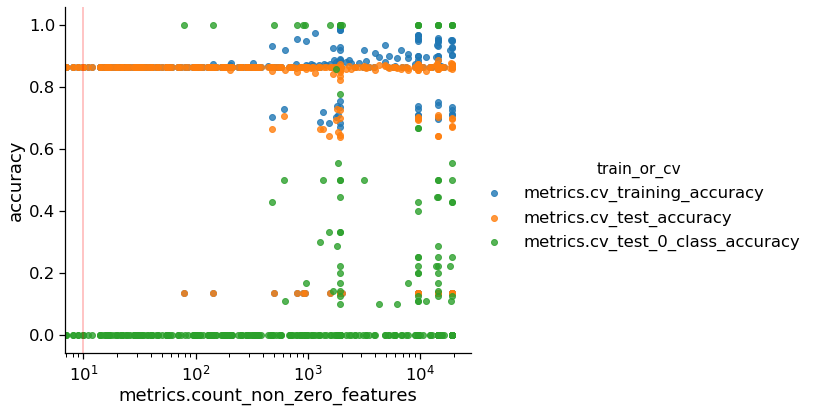

In [52]:
sns.lmplot(x='metrics.count_non_zero_features',
           y='accuracy',
           data=experiment_results_v6_df_melt,
           hue='train_or_cv',
           fit_reg=False, size=6, aspect=1.25)

ax = plt.gca()
ax.set_xscale('log')
ax.axvline(10, c='r', alpha=0.3)
#ax.set_ylim([0.5, 1.1])

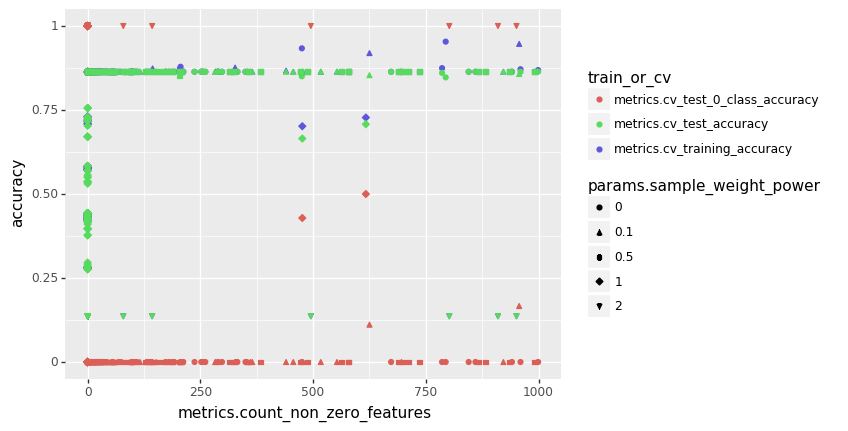

<ggplot: (8726253168137)>

In [86]:
plot_df = experiment_results_v6_df_melt.copy()#.loc[experiment_results_v6_df_melt['params.log10_max_iter'] == '3.0']

(ggplot(data=plot_df) 
 + geom_point(aes(x='metrics.count_non_zero_features', 
                  y='accuracy', 
                  color='train_or_cv', 
                  shape='params.sample_weight_power'))
 + coord_cartesian(xlim=[0,1000]))

### Does removing genes based on CoV help?

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/plotnine/stats/stat.py:311: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  stats = pd.concat(stats, axis=0, ignore_index=True)


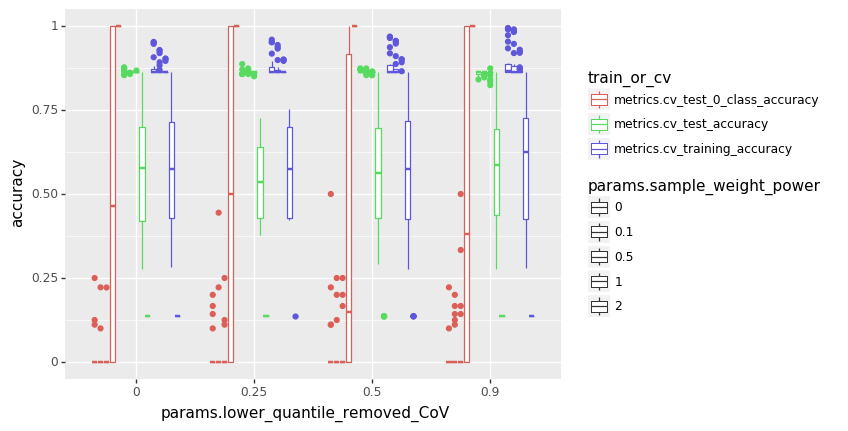

<ggplot: (8726181611125)>

In [93]:
plot_df = experiment_results_v6_df_melt.copy()#.loc[experiment_results_v6_df_melt['params.log10_max_iter'] == '3.0']

(ggplot(data=plot_df) 
 + geom_boxplot(aes(x='params.lower_quantile_removed_CoV', 
                  y='accuracy', 
                  color='train_or_cv', 
                  shape='params.sample_weight_power'))
)

* There doesn't seem to be a huge difference with what fraction of genes are removed prior to modeling. I will start by removing the 25th quantile.
* Furthermore, using `sample_weight_power` < 1 shows quite poor performance for the class 0 cases
* Using `sample_weight_power`=2 has the opposite effect where the performance of the class 1 cases is poor
* Therefore, using a `sample_weight_power` approximately equal to 1 seems to be the way to go

# V7 - Experiment with sample weights near 1.0

## Running mlflow

In [100]:
%%time

# Set the experiment name
mlflow.set_tracking_uri(f'file://{experiment_base_path}')
mlflow.set_experiment('V7-l1-Logistic_Regression_Exp')
    
# Define the parameter grid
param_dict = {'C': np.logspace(-2, 0, 10).tolist() + np.logspace(1, 5, 3).tolist(),
             'max_iter': [100, 1000],
             'solver': ['saga'],
             'class_weight': [None],
             'lower_quantile_removed_CoV': [0, 0.25, 0.5, 0.9],
             'sample_weight_power': [0.8, 0.9, 1.0, 1.1, 1.2, 1.3]}

# Run mlflow runs in parallel
results = joblib.Parallel(n_jobs=-1, backend='multiprocessing')\
    (joblib.delayed(run_mlflow_exp_v6)(curr_param_index, curr_params_dict)\
         for curr_param_index, curr_params_dict in enumerate(ParameterGrid(param_dict)))

INFO: 'V7-l1-Logistic_Regression_Exp' does not exist. Creating a new experiment


/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

CPU times: user 1.9 s, sys: 800 ms, total: 2.7 s
Wall time: 29min 3s


## Generating the results dataframe

In [157]:
# Get the experiment id from the experiment name
curr_experiment_id=mlflow.get_experiment_by_name('V7-l1-Logistic_Regression_Exp').experiment_id

experiment_results_v7_df = mlflow.search_runs(experiment_ids=curr_experiment_id)

# Melt the dataframe to get accuracy as a single column
experiment_results_v7_df_melt = experiment_results_v7_df\
    .melt(id_vars=['run_id','metrics.count_non_zero_features','params.lower_quantile_removed_CoV','params.log10_C','params.log10_max_iter','params.sample_weight_power'],
          value_vars=['metrics.cv_training_accuracy','metrics.cv_test_accuracy','metrics.cv_test_0_class_accuracy'],
          var_name='train_or_cv',
          value_name='accuracy')

## Plotting a boxplot of sample weight powers

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/plotnine/stats/stat.py:311: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  stats = pd.concat(stats, axis=0, ignore_index=True)


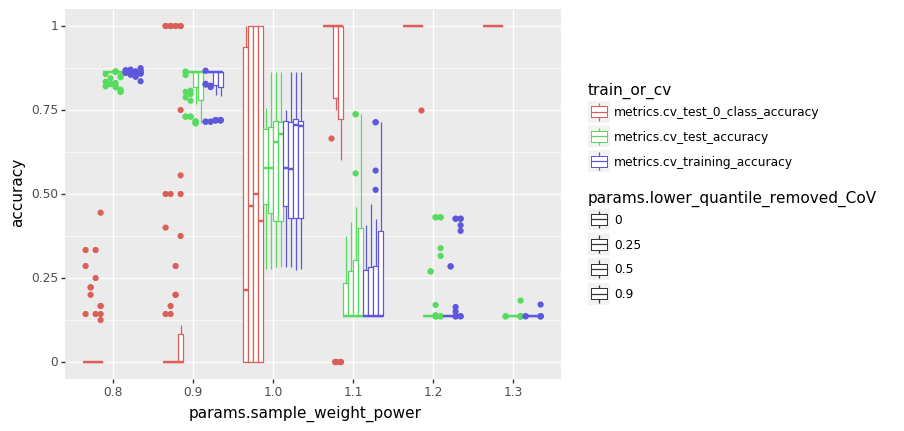

<ggplot: (8726187021633)>

In [103]:
plot_df = experiment_results_v7_df_melt.copy()#.loc[experiment_results_v6_df_melt['params.log10_max_iter'] == '3.0']

(ggplot(data=plot_df) 
 + geom_boxplot(aes(x='params.sample_weight_power', 
                  y='accuracy', 
                  color='train_or_cv', 
                  shape='params.lower_quantile_removed_CoV'))
)

* Using sample_weight power of 1 is the the most balanced method for sample weighting

In [144]:
experiment_results_v7_df_melt_v1 = experiment_results_v7_df_melt\
    .loc[experiment_results_v7_df_melt['params.sample_weight_power'] == '1.0']

experiment_results_v7_df_melt_v1.head()

,run_id,metrics.count_non_zero_features,params.lower_quantile_removed_CoV,params.log10_C,params.log10_max_iter,params.sample_weight_power,train_or_cv,accuracy
3,56bf95ed735b4eb6b346602bfe6d63ec,1934.0,0.9,5.0,3.0,1.0,metrics.cv_training_accuracy,0.724253
9,ecef225fd6ab47acae78e09e51f3f1ab,1934.0,0.9,5.0,2.0,1.0,metrics.cv_training_accuracy,0.706808
15,a8bfa4e37c334eebb02b46d80a827ef2,9668.0,0.5,5.0,3.0,1.0,metrics.cv_training_accuracy,0.729232
21,a15127458fb148e2a2f93a12101d8b90,9668.0,0.5,5.0,2.0,1.0,metrics.cv_training_accuracy,0.703496
27,d80112d1de69443bb067ff6fd993121a,14501.0,0.25,5.0,3.0,1.0,metrics.cv_training_accuracy,0.732555


## Plotting a boxplot of lower_quantile_removed_CoV

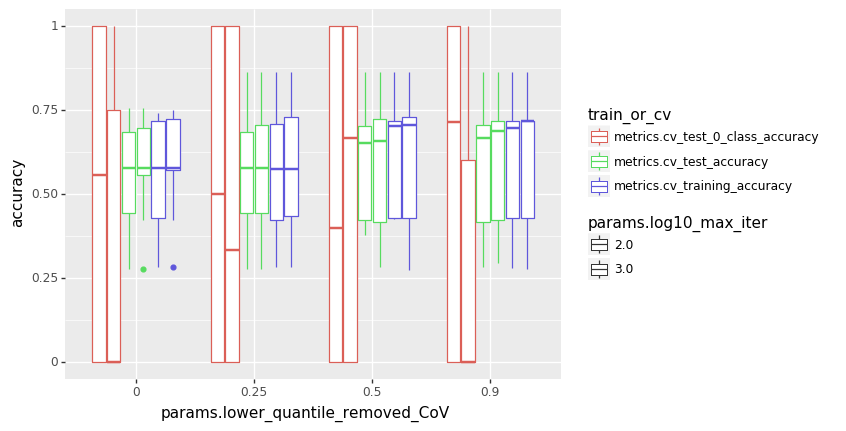

<ggplot: (8726183515433)>

In [105]:
plot_df = experiment_results_v7_df_melt_v1.copy()

(ggplot(data=plot_df) 
 + geom_boxplot(aes(x='params.lower_quantile_removed_CoV', 
                  y='accuracy', 
                  color='train_or_cv', 
                  shape='params.log10_max_iter'))
)

* Using 1000 iterations does not definitively improve/worsen things here
* Removing the lower 0.5 quantile does improve test accuracy pretty significantly

In [117]:
experiment_results_v7_df_melt_v2 = experiment_results_v7_df_melt_v1\
    .loc[(experiment_results_v7_df_melt_v1['params.lower_quantile_removed_CoV'] == '0.5') \
         & (experiment_results_v7_df_melt_v1['params.log10_max_iter'] == '2.0')]

experiment_results_v7_df_melt_v2.head()

,run_id,metrics.count_non_zero_features,params.lower_quantile_removed_CoV,params.log10_C,params.log10_max_iter,params.sample_weight_power,train_or_cv,accuracy
21,a15127458fb148e2a2f93a12101d8b90,9668.0,0.5,5.0,2.0,1.0,metrics.cv_training_accuracy,0.703496
69,262aff3a04a74f08ae0044828f2dfb48,9657.0,0.5,3.0,2.0,1.0,metrics.cv_training_accuracy,0.710947
117,9a7747b94ba1413eaecb68d6fcc0cc09,2137.0,0.5,1.0,2.0,1.0,metrics.cv_training_accuracy,0.704319
165,6082239572ff4de9865d931c799751c5,0.0,0.5,0.0,2.0,1.0,metrics.cv_training_accuracy,0.424779
213,702ab85f8f394f2c8034d80aabe1d146,0.0,0.5,-0.22222222222222227,2.0,1.0,metrics.cv_training_accuracy,0.434741


## Plotting a boxplot of C

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

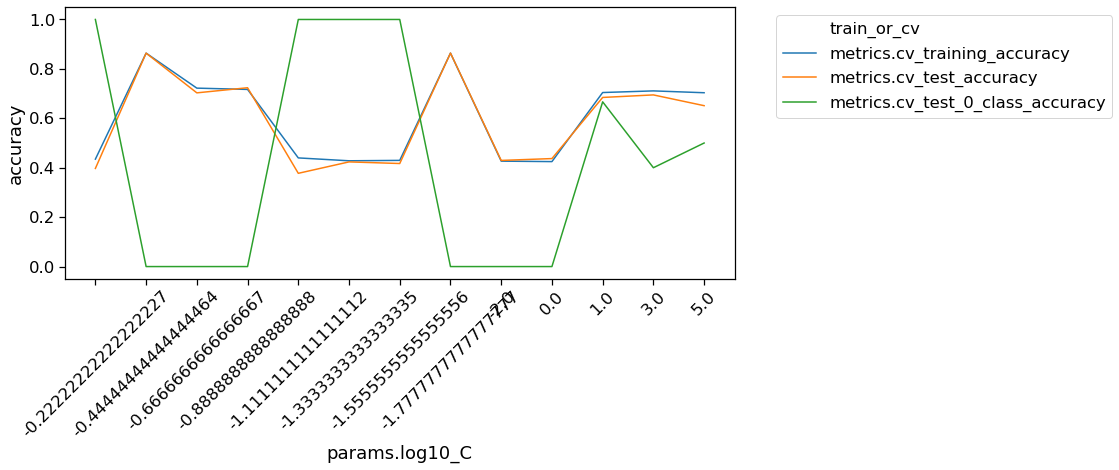

In [137]:
plt.figure(figsize=(12,5))
sns.lineplot(x='params.log10_C',
             y='accuracy',
             data=experiment_results_v7_df_melt_v2,
             hue='train_or_cv')

ax = plt.gca()
plt.xticks(rotation=45)
ax.legend(bbox_to_anchor=(1.05,1))

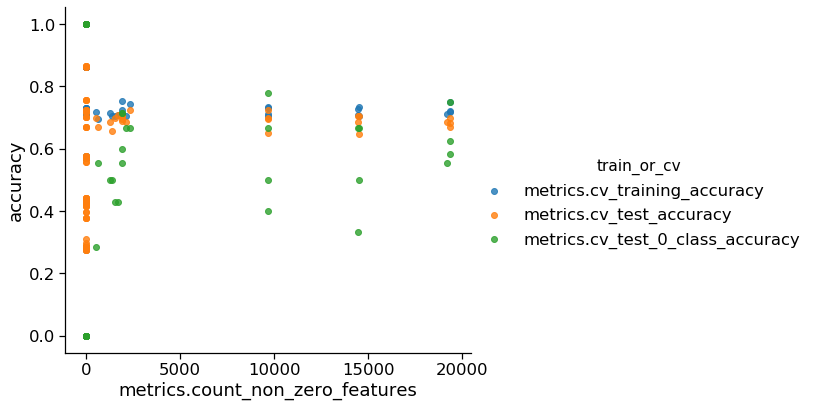

In [152]:
sns.lmplot(x='metrics.count_non_zero_features',
           y='accuracy',
           data=experiment_results_v7_df_melt_v1,
           hue='train_or_cv', 
           fit_reg=False, size=6, aspect=1.25)

ax = plt.gca()
#ax.set_xscale('log')
#ax.axvline(10, c='r', alpha=0.3)

In [155]:
experiment_results_v7_df_melt_v1.loc[experiment_results_v7_df_melt_v1['metrics.count_non_zero_features']]

,run_id,metrics.count_non_zero_features,params.lower_quantile_removed_CoV,params.log10_C,params.log10_max_iter,params.sample_weight_power,train_or_cv,accuracy
3,56bf95ed735b4eb6b346602bfe6d63ec,1934.0,0.9,5.0,3.0,1.0,metrics.cv_training_accuracy,0.724253
9,ecef225fd6ab47acae78e09e51f3f1ab,1934.0,0.9,5.0,2.0,1.0,metrics.cv_training_accuracy,0.706808
15,a8bfa4e37c334eebb02b46d80a827ef2,9668.0,0.5,5.0,3.0,1.0,metrics.cv_training_accuracy,0.729232
21,a15127458fb148e2a2f93a12101d8b90,9668.0,0.5,5.0,2.0,1.0,metrics.cv_training_accuracy,0.703496
27,d80112d1de69443bb067ff6fd993121a,14501.0,0.25,5.0,3.0,1.0,metrics.cv_training_accuracy,0.732555
...,...,...,...,...,...,...,...,...
1845,e6458929b4714c28b0a80a27be886733,0.0,0.5,-2.0,2.0,1.0,metrics.cv_test_0_class_accuracy,0.000000
1851,a1726d2e8ede48d2a2e91b81ed32632d,0.0,0.25,-2.0,3.0,1.0,metrics.cv_test_0_class_accuracy,1.000000
1856,948680de54ed4fcbb84c8c59c03058f8,0.0,0.25,-2.0,2.0,1.0,metrics.cv_test_0_class_accuracy,1.000000
1865,c53b27b80f9947db8c0a083b55821ccb,0.0,0,-2.0,3.0,1.0,metrics.cv_test_0_class_accuracy,1.000000


,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.cv_test_accuracy,metrics.cv_test_0_class_accuracy,metrics.cv_training_accuracy,metrics.count_non_zero_features,params.class_weight,params.log10_max_iter,params.log10_C,params.lower_quantile_removed_CoV,params.solver,params.sample_weight_power,tags.mlflow.user,tags.mlflow.source.type,tags.mlflow.source.name
0,9199bedd8c9b4bbd88ab5e530bbfef9f,7,FINISHED,file:///home/alex/data-science/brain_cancer_pr...,2020-01-19 21:41:00.092000+00:00,2020-01-19 21:41:59.206000+00:00,0.182842,1.000000,0.171110,1934.0,None,3.0,5.0,0.9,saga,1.3,alex,LOCAL,/home/alex/miniconda3/envs/precfda_bc/lib/pyth...
1,c5af4abd1e0745cd84ed97017ca8cabc,7,FINISHED,file:///home/alex/data-science/brain_cancer_pr...,2020-01-19 21:40:59.766000+00:00,2020-01-19 21:41:58.710000+00:00,0.338579,0.750000,0.406992,1934.0,None,3.0,5.0,0.9,saga,1.2,alex,LOCAL,/home/alex/miniconda3/envs/precfda_bc/lib/pyth...
2,ce44e49676164836905e8ed9a6dd77dd,7,FINISHED,file:///home/alex/data-science/brain_cancer_pr...,2020-01-19 21:40:56.910000+00:00,2020-01-19 21:41:56.488000+00:00,0.564809,0.666667,0.607182,1934.0,None,3.0,5.0,0.9,saga,1.1,alex,LOCAL,/home/alex/miniconda3/envs/precfda_bc/lib/pyth...
3,56bf95ed735b4eb6b346602bfe6d63ec,7,FINISHED,file:///home/alex/data-science/brain_cancer_pr...,2020-01-19 21:40:55.004000+00:00,2020-01-19 21:41:55.028000+00:00,0.687978,0.555556,0.724253,1934.0,None,3.0,5.0,0.9,saga,1.0,alex,LOCAL,/home/alex/miniconda3/envs/precfda_bc/lib/pyth...
4,6bfd1f47379a479d83a19914e96a8915,7,FINISHED,file:///home/alex/data-science/brain_cancer_pr...,2020-01-19 21:40:53.578000+00:00,2020-01-19 21:41:52.694000+00:00,0.757596,0.555556,0.790702,1934.0,None,3.0,5.0,0.9,saga,0.9,alex,LOCAL,/home/alex/miniconda3/envs/precfda_bc/lib/pyth...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
617,c53b27b80f9947db8c0a083b55821ccb,7,FINISHED,file:///home/alex/data-science/brain_cancer_pr...,2020-01-19 21:17:12.211000+00:00,2020-01-19 21:17:24.863000+00:00,0.570328,1.000000,0.573323,0.0,None,3.0,-2.0,0,saga,1.0,alex,LOCAL,/home/alex/miniconda3/envs/precfda_bc/lib/pyth...
619,7ae098ba1f2c4ee2b75d51e22403bf34,7,FINISHED,file:///home/alex/data-science/brain_cancer_pr...,2020-01-19 21:17:12.210000+00:00,2020-01-19 21:17:24.417000+00:00,0.136339,1.000000,0.136221,0.0,None,2.0,-2.0,0,saga,1.2,alex,LOCAL,/home/alex/miniconda3/envs/precfda_bc/lib/pyth...
620,8e5cd737ccd243fcb1597373ba281b55,7,FINISHED,file:///home/alex/data-science/brain_cancer_pr...,2020-01-19 21:17:12.210000+00:00,2020-01-19 21:17:24.392000+00:00,0.570328,1.000000,0.573323,0.0,None,2.0,-2.0,0,saga,1.0,alex,LOCAL,/home/alex/miniconda3/envs/precfda_bc/lib/pyth...
621,ae16e64965d04dbabbd06ad49be0090b,7,FINISHED,file:///home/alex/data-science/brain_cancer_pr...,2020-01-19 21:17:12.210000+00:00,2020-01-19 21:17:24.782000+00:00,0.136339,1.000000,0.136221,0.0,None,2.0,-2.0,0,saga,1.3,alex,LOCAL,/home/alex/miniconda3/envs/precfda_bc/lib/pyth...


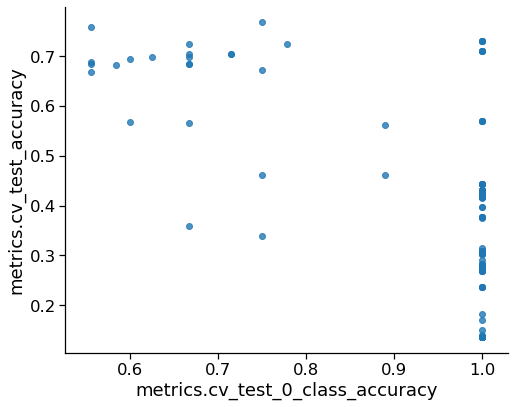

In [165]:
plot_df = experiment_results_v7_df.loc[experiment_results_v7_df['metrics.cv_test_0_class_accuracy'] > 0.5].copy()

sns.lmplot(x='metrics.cv_test_0_class_accuracy',
           y='metrics.cv_test_accuracy',
           data=plot_df,
           fit_reg=False, size=6, aspect=1.25)

ax = plt.gca()
#ax.set_xscale('log')
#ax.axvline(10, c='r', alpha=0.3)

In [179]:
experiment_results_v7_df.loc[(experiment_results_v7_df['metrics.cv_test_0_class_accuracy'] > 0.7)\
                             & (experiment_results_v7_df['metrics.cv_test_accuracy'] > 0.6)\
                            & (experiment_results_v7_df['metrics.count_non_zero_features'] < 500)]

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.cv_test_accuracy,metrics.cv_test_0_class_accuracy,metrics.cv_training_accuracy,metrics.count_non_zero_features,params.class_weight,params.log10_max_iter,params.log10_C,params.lower_quantile_removed_CoV,params.solver,params.sample_weight_power,tags.mlflow.user,tags.mlflow.source.type,tags.mlflow.source.name
96,64e0b41a591a4c8a8b37707355e87c4a,7,FINISHED,file:///home/alex/data-science/brain_cancer_pr...,2020-01-19 21:28:31.061000+00:00,2020-01-19 21:29:20.553000+00:00,0.136230,1.000000,0.136214,192.0,None,3.0,1.0,0.9,saga,1.3,alex,LOCAL,/home/alex/miniconda3/envs/precfda_bc/lib/pyth...
97,d05a8435ca72421f838c20956fd98896,7,FINISHED,file:///home/alex/data-science/brain_cancer_pr...,2020-01-19 21:28:26.875000+00:00,2020-01-19 21:29:16.700000+00:00,0.136175,1.000000,0.136210,146.0,None,3.0,1.0,0.9,saga,1.2,alex,LOCAL,/home/alex/miniconda3/envs/precfda_bc/lib/pyth...
98,d52ab7e53fa043538128db8124c5e45c,7,FINISHED,file:///home/alex/data-science/brain_cancer_pr...,2020-01-19 21:28:26.724000+00:00,2020-01-19 21:29:17.429000+00:00,0.461858,0.888889,0.489212,380.0,None,3.0,1.0,0.9,saga,1.1,alex,LOCAL,/home/alex/miniconda3/envs/precfda_bc/lib/pyth...
104,856ff9ec6e82467589885c96d3c2fa70,7,FINISHED,file:///home/alex/data-science/brain_cancer_pr...,2020-01-19 21:28:12.883000+00:00,2020-01-19 21:28:23.687000+00:00,0.136284,1.000000,0.136217,421.0,None,2.0,1.0,0.9,saga,1.1,alex,LOCAL,/home/alex/miniconda3/envs/precfda_bc/lib/pyth...
144,2986ba28362e436493b2be0497a23ed2,7,FINISHED,file:///home/alex/data-science/brain_cancer_pr...,2020-01-19 21:24:38.852000+00:00,2020-01-19 21:24:52.933000+00:00,0.136011,1.000000,0.136200,0.0,None,3.0,0.0,0.9,saga,1.3,alex,LOCAL,/home/alex/miniconda3/envs/precfda_bc/lib/pyth...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
619,7ae098ba1f2c4ee2b75d51e22403bf34,7,FINISHED,file:///home/alex/data-science/brain_cancer_pr...,2020-01-19 21:17:12.210000+00:00,2020-01-19 21:17:24.417000+00:00,0.136339,1.000000,0.136221,0.0,None,2.0,-2.0,0,saga,1.2,alex,LOCAL,/home/alex/miniconda3/envs/precfda_bc/lib/pyth...
620,8e5cd737ccd243fcb1597373ba281b55,7,FINISHED,file:///home/alex/data-science/brain_cancer_pr...,2020-01-19 21:17:12.210000+00:00,2020-01-19 21:17:24.392000+00:00,0.570328,1.000000,0.573323,0.0,None,2.0,-2.0,0,saga,1.0,alex,LOCAL,/home/alex/miniconda3/envs/precfda_bc/lib/pyth...
621,ae16e64965d04dbabbd06ad49be0090b,7,FINISHED,file:///home/alex/data-science/brain_cancer_pr...,2020-01-19 21:17:12.210000+00:00,2020-01-19 21:17:24.782000+00:00,0.136339,1.000000,0.136221,0.0,None,2.0,-2.0,0,saga,1.3,alex,LOCAL,/home/alex/miniconda3/envs/precfda_bc/lib/pyth...
622,b817cdc3f6294f3d85eb53b195e4dd39,7,FINISHED,file:///home/alex/data-science/brain_cancer_pr...,2020-01-19 21:17:12.210000+00:00,2020-01-19 21:17:25.030000+00:00,0.136339,1.000000,0.136221,0.0,None,2.0,-2.0,0,saga,1.1,alex,LOCAL,/home/alex/miniconda3/envs/precfda_bc/lib/pyth...


In [182]:
experiment_results_v7_df.loc[(experiment_results_v7_df['metrics.count_non_zero_features'] > 0) \
                            & (experiment_results_v7_df['metrics.count_non_zero_features'] < 500)\
                            & (experiment_results_v7_df['metrics.cv_test_0_class_accuracy'] > 0.5)]

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.cv_test_accuracy,metrics.cv_test_0_class_accuracy,metrics.cv_training_accuracy,metrics.count_non_zero_features,params.class_weight,params.log10_max_iter,params.log10_C,params.lower_quantile_removed_CoV,params.solver,params.sample_weight_power,tags.mlflow.user,tags.mlflow.source.type,tags.mlflow.source.name
96,64e0b41a591a4c8a8b37707355e87c4a,7,FINISHED,file:///home/alex/data-science/brain_cancer_pr...,2020-01-19 21:28:31.061000+00:00,2020-01-19 21:29:20.553000+00:00,0.136230,1.000000,0.136214,192.0,None,3.0,1.0,0.9,saga,1.3,alex,LOCAL,/home/alex/miniconda3/envs/precfda_bc/lib/pyth...
97,d05a8435ca72421f838c20956fd98896,7,FINISHED,file:///home/alex/data-science/brain_cancer_pr...,2020-01-19 21:28:26.875000+00:00,2020-01-19 21:29:16.700000+00:00,0.136175,1.000000,0.136210,146.0,None,3.0,1.0,0.9,saga,1.2,alex,LOCAL,/home/alex/miniconda3/envs/precfda_bc/lib/pyth...
98,d52ab7e53fa043538128db8124c5e45c,7,FINISHED,file:///home/alex/data-science/brain_cancer_pr...,2020-01-19 21:28:26.724000+00:00,2020-01-19 21:29:17.429000+00:00,0.461858,0.888889,0.489212,380.0,None,3.0,1.0,0.9,saga,1.1,alex,LOCAL,/home/alex/miniconda3/envs/precfda_bc/lib/pyth...
104,856ff9ec6e82467589885c96d3c2fa70,7,FINISHED,file:///home/alex/data-science/brain_cancer_pr...,2020-01-19 21:28:12.883000+00:00,2020-01-19 21:28:23.687000+00:00,0.136284,1.000000,0.136217,421.0,None,2.0,1.0,0.9,saga,1.1,alex,LOCAL,/home/alex/miniconda3/envs/precfda_bc/lib/pyth...
157,e5de03c0fde24620aebe51e56e11c5ae,7,FINISHED,file:///home/alex/data-science/brain_cancer_pr...,2020-01-19 21:23:27.729000+00:00,2020-01-19 21:26:58.187000+00:00,0.136284,1.000000,0.136217,1.0,None,3.0,0.0,0.5,saga,1.2,alex,LOCAL,/home/alex/miniconda3/envs/precfda_bc/lib/pyth...
163,ac1c8448ee8a4fc4b794ee6351307634,7,FINISHED,file:///home/alex/data-science/brain_cancer_pr...,2020-01-19 21:22:54.510000+00:00,2020-01-19 21:23:20.093000+00:00,0.136011,1.000000,0.136200,3.0,None,2.0,0.0,0.5,saga,1.2,alex,LOCAL,/home/alex/miniconda3/envs/precfda_bc/lib/pyth...
169,4333e161d33b474e9b0a7a7abf907231,7,FINISHED,file:///home/alex/data-science/brain_cancer_pr...,2020-01-19 21:22:19.505000+00:00,2020-01-19 21:26:48.375000+00:00,0.136284,1.000000,0.136217,2.0,None,3.0,0.0,0.25,saga,1.2,alex,LOCAL,/home/alex/miniconda3/envs/precfda_bc/lib/pyth...
175,9e2b8ff9e0d740acacefabb0b0cf401a,7,FINISHED,file:///home/alex/data-science/brain_cancer_pr...,2020-01-19 21:22:06.629000+00:00,2020-01-19 21:22:42.556000+00:00,0.136230,1.000000,0.136214,2.0,None,2.0,0.0,0.25,saga,1.2,alex,LOCAL,/home/alex/miniconda3/envs/precfda_bc/lib/pyth...
181,dd38b35faaf64ff2bbd5d1fb3951e8d8,7,FINISHED,file:///home/alex/data-science/brain_cancer_pr...,2020-01-19 21:21:27.717000+00:00,2020-01-19 21:28:31.043000+00:00,0.136339,1.000000,0.136221,13.0,None,3.0,0.0,0,saga,1.2,alex,LOCAL,/home/alex/miniconda3/envs/precfda_bc/lib/pyth...
186,46f39d7b74194c8595cea6e05f8b09fe,7,FINISHED,file:///home/alex/data-science/brain_cancer_pr...,2020-01-19 21:21:18.031000+00:00,2020-01-19 21:22:08.288000+00:00,0.136230,1.000000,0.136214,2.0,None,2.0,0.0,0,saga,1.3,alex,LOCAL,/home/alex/miniconda3/envs/precfda_bc/lib/pyth...


* There were no models that had < 500 features and > 50% accuracy on the class 0 cases